## Import & Mount

In [171]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [172]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## 00.대회 정보 살펴보기

- [대회링크](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

## 01.Data Load

In [173]:
# 데이터 경로
train_data_path = '/content/drive/MyDrive/github/아이펠/data/house_price_Regression/train.csv'
test_data_path = '/content/drive/MyDrive/github/아이펠/data/house_price_Regression/test.csv'
submission_data_path = '/content/drive/MyDrive/github/아이펠/data/house_price_Regression/sample_submission.csv'

# read_csv
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
submission_df = pd.read_csv(submission_data_path)
print('train data dim : {}'.format(train_df.shape))
print('test data dim : {}'.format(test_df.shape))
print('submission data dim : {}'.format(submission_df.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)
submission data dim : (6468, 2)


In [174]:
# 타겟 분류
y = pd.DataFrame({
    'price' : train_df['price'],
})
del train_df['price']

In [175]:
# concat
train_len = len(train_df)
data = pd.concat((train_df, test_df), axis=0)
print('data dim : {}'.format(data.shape))

data dim : (21503, 20)


## 02.간단한 전처리
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.

<Axes: >

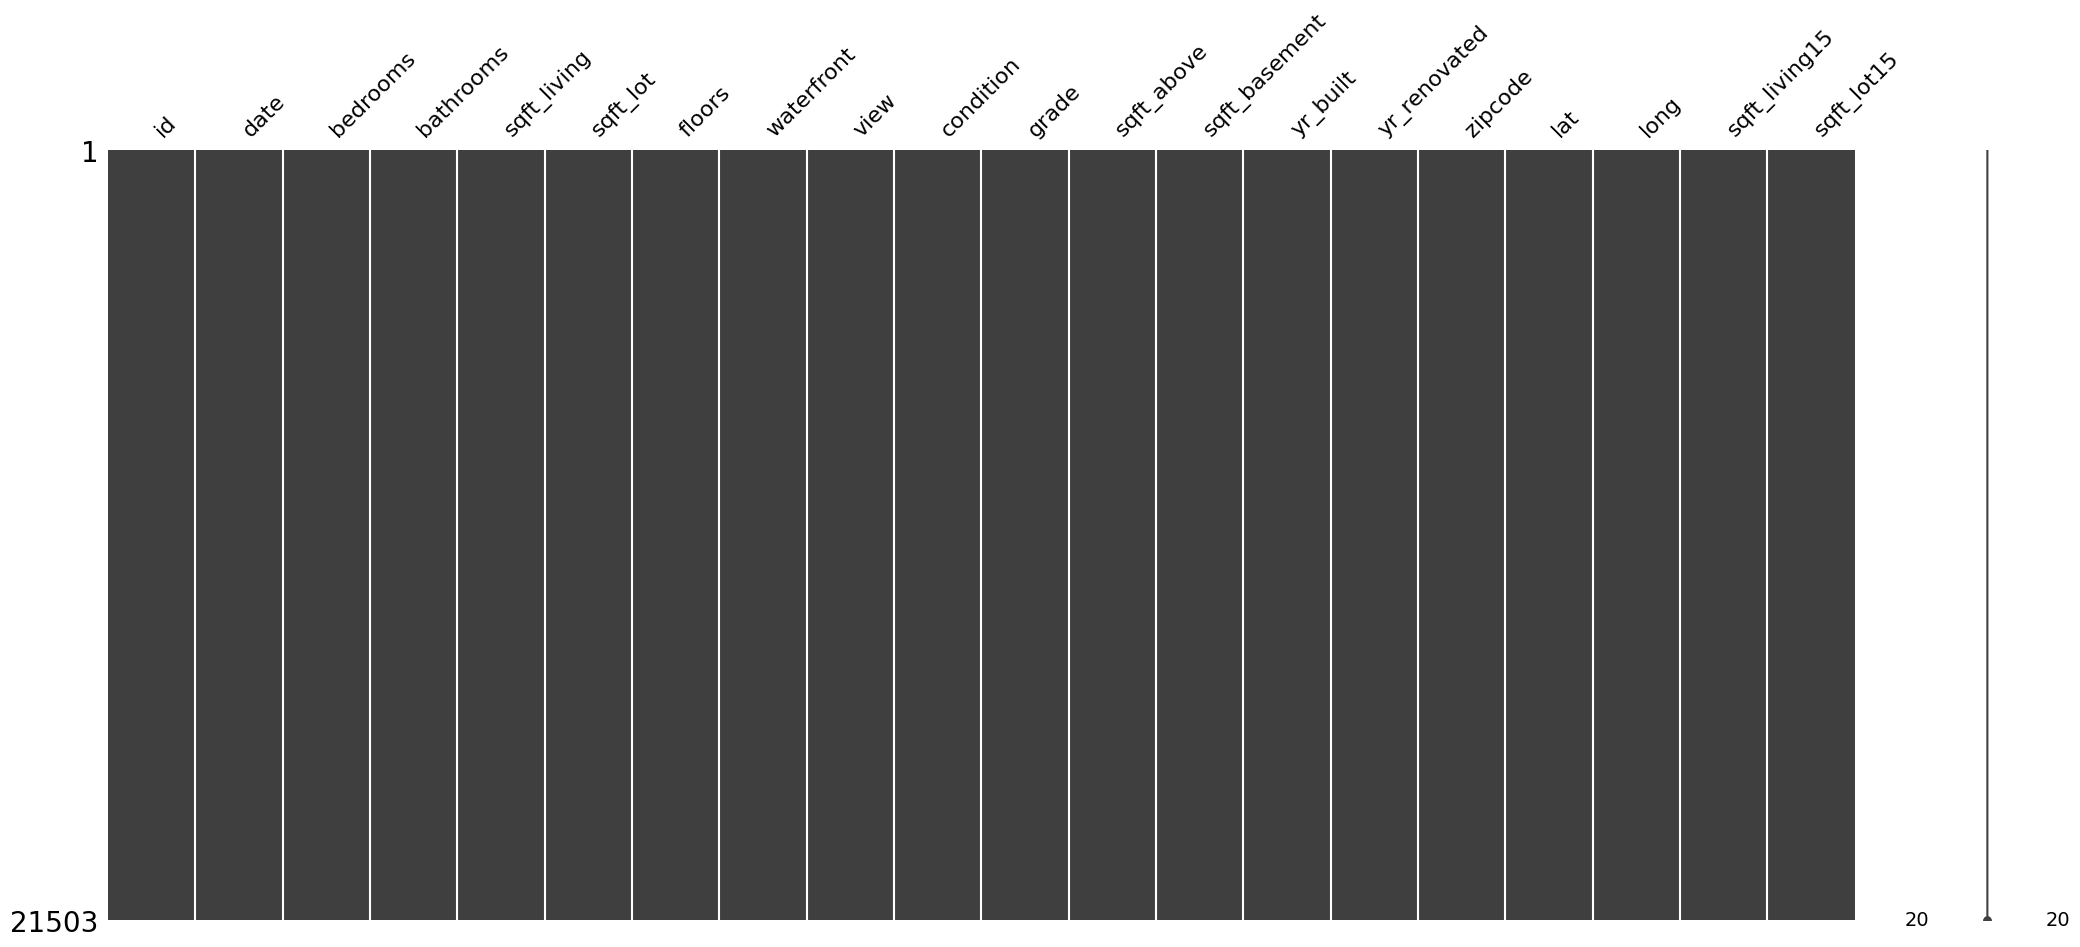

In [176]:
# 결측치 확인
# - 결측치 없음
msno.matrix(data)

In [177]:
# 결측치 확인 - 없음
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### date 분해

In [178]:
# 컬럼 분할
data['yy'] = data['date'].str[:4]
data['mm'] = data['date'].str[4:6]
data['dd'] = data['date'].str[6:8]

### Log-Scaling


#### 타겟(Price)

Text(0.5, 1.0, 'price_log')

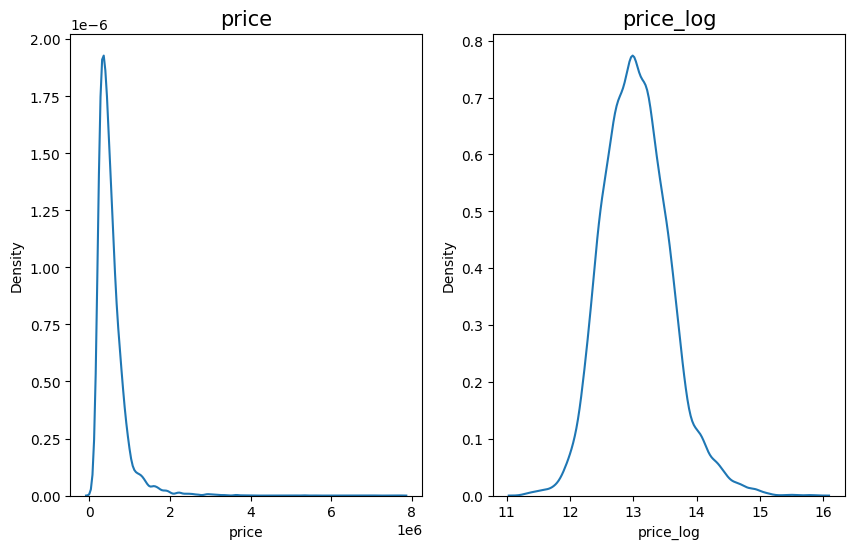

In [179]:
# log-scaling , 타겟
y['price_log'] = np.log1p(y.values)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(10,6))

sns.kdeplot(y['price'], ax=ax[0])
ax[0].set_title('price', fontsize=15)

sns.kdeplot(y['price_log'], ax=ax[1])
ax[1].set_title('price_log', fontsize=15)

#### 각 변수들의 분포 확인

한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

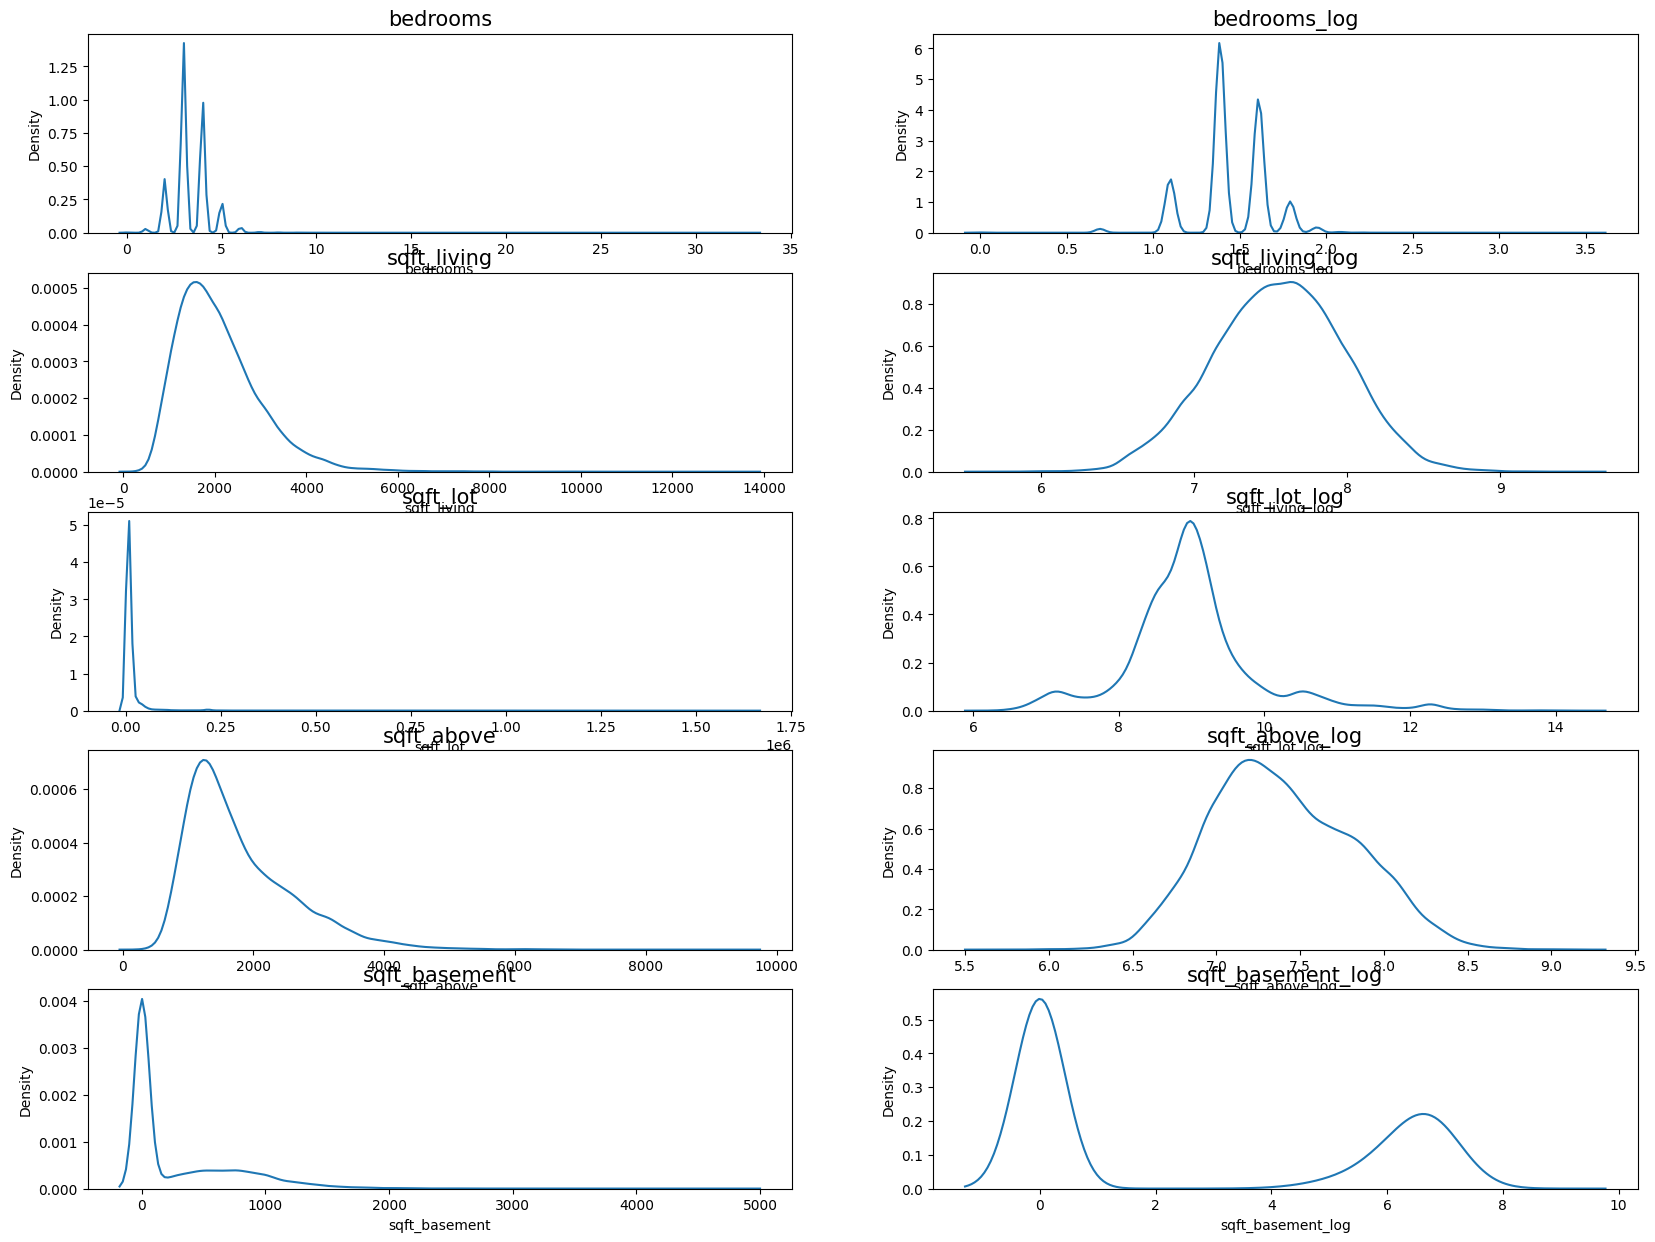

In [180]:
# log-scaling
# 한쪽으로 치우치는 컬럼 - 정규분포 가깝게 만들기
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[f'{c}_log'] = np.log1p(data[c].values)

# log-scaling 결과 확인, before + affer
fig, ax = plt.subplots(len(skew_columns), 2, figsize=(20, 15))

for i, col in enumerate(skew_columns):
    sns.kdeplot(data[col], ax=ax[i][0]) # befor
    ax[i][0].set_title(f'{col}', fontsize=15)
    sns.kdeplot(data[f'{col}_log'], ax=ax[i][1]) # affer
    ax[i][1].set_title(f'{col}_log', fontsize=15)



### train, test 나누기

In [181]:
# train , test 분리
test = data[data['id'].isin(test_df['id'])]
x = data[~data['id'].isin(test_df['id'])]

### id 제거

In [182]:
# id 컬럼 삭제
del x['id']

In [183]:
print(x.shape, y.shape, test.shape)

(15035, 27) (15035, 2) (6468, 28)


## 03.모델링

### setting

In [184]:
def rmse_expm1(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [185]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [186]:
def get_scores(models, x, y, col_name):
    df = {}
    for model in models:
        # train, test 데이터셋 분리
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        model_name = model['name']
        model = model['model']
        model.fit(x_train,y_train)

        # 예측
        y_pred = model.predict(x_test)

        # 예측 결과의 rmse값 저장
        if 'price' == y.name :
          df[model_name] = rmse(y_test, y_pred)
        else:
          df[model_name] = rmse_expm1(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index=[col_name]).T.sort_values(col_name, ascending=False)

    return score_df

In [187]:
# 랜덤 시드 고정
random_state = 0xC00FFEE

gb = GradientBoostingRegressor(random_state=random_state)
xgb = xgb.XGBRegressor(random_state=random_state)
lgbm = lgb.LGBMRegressor(random_state=random_state)
rf = RandomForestRegressor(random_state=random_state)

models = [
    {'model':gb, 'name':'GradientBoosting'},
    {'model':xgb, 'name':'XGBoost'},
    {'model':lgbm, 'name':'LightGBM'},
    {'model':rf, 'name':'RandomForest'},
]

### (실험)log로 분포 바꾸는 것이 성능이 좋을까?

- 실험 4가지
  1. un_log + un_price
  2. un_log + price_log
  3. log + un_price
  4. `log + price_log`

- 결과 : 모델마다 log 적용하고 안하고 차이가 있음, `4번` 기준으로 이후 진행함!

In [188]:
# log 적용 / 미적용 분리
x_on_log = x.drop(['date','yy','mm','dd', 'bedrooms',	'sqft_living',	'sqft_lot',	'sqft_above',	'sqft_basement'],axis=1)
x_non_log = x.drop(['date','yy','mm','dd', 'bedrooms_log',	'sqft_living_log',	'sqft_lot_log',	'sqft_above_log',	'sqft_basement_log'],axis=1)

# Score 얻기
score_df = get_scores(models, x_non_log, y['price'], 'un_log/un_price' )
score_df = pd.concat([score_df,get_scores(models, x_non_log, y['price_log'], 'un_log/price_log' )],axis=1)
score_df = pd.concat([score_df,get_scores(models, x_on_log, y['price'], 'log/un_price' )],axis=1)
score_df = pd.concat([score_df,get_scores(models, x_on_log, y['price_log'], 'log/price_log' )],axis=1)

# Score 평균 얻기
mean_df = pd.DataFrame(score_df.apply(lambda x : np.mean(x)).values,columns=['평균']).T
mean_df.columns = ['un_log/un_price',	'un_log/price_log',	'log/un_price',	'log/price_log']
score_df = pd.concat([score_df,mean_df],axis=0)
score_df

,un_log/un_price,un_log/price_log,log/un_price,log/price_log
GradientBoosting,144243.569699,155030.801481,141596.311259,155034.826353
LightGBM,138871.518506,131633.934618,138848.758264,131631.144593
RandomForest,131048.868040,136084.852822,131002.672464,136651.111541
XGBoost,130651.671143,147942.616827,131465.596242,146678.296506
평균,136203.906847,142673.051437,135728.334557,142498.844748


### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [189]:
def get_cv_score(models,x,y ):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x. values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [190]:
get_cv_score(models, x_on_log, y['price_log'] )

Model: GradientBoosting, CV score:0.8778
Model: XGBoost, CV score:0.8931
Model: LightGBM, CV score:0.8999
Model: RandomForest, CV score:0.8845


## Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [191]:
def AveragingBlending(models, x, y, sub_x):
    for m in models :
        m['model'].fit(x.values, y)

    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [193]:
y_pred = AveragingBlending(models, x_on_log, y['price_log'], test.drop('id',axis=1)[x_on_log.columns])

In [194]:
sub = pd.DataFrame(data={'id':test['id'],'price':y_pred})
sub

,id,price
0,15035,13.131713
1,15036,13.051614
2,15037,14.117466
3,15038,12.579329
4,15039,12.672426
...,...,...
6463,21498,12.379993
6464,21499,12.919572
6465,21500,13.013225
6466,21501,12.735929


In [195]:
sub.to_csv('submission.csv', index=False)